# Predicting departure delays

Final assignment of ML ods.ai course.

[Kaggle InClass competition](https://www.kaggle.com/c/flight-delays-2017/overview)

Predict departure delays of 15 minutes or more. The departure time, the carrier airline, the place of departure and destination, and the distance between them are known. The predicted feature is binary, the target metric is ROC AUC.

--------------------------------------------------

Advance preparation needed for work with Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

### Step 1: import libraries, make work directory and load data

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from package import MakeFeatures, make_predict

R_STATE = 17

In [5]:
PATH_ANS = 'csv'

if not os.path.exists(PATH_ANS):
    os.mkdir(PATH_ANS)

Load and check data

In [6]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [7]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Visualize target feature

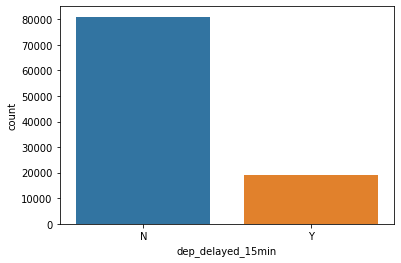

In [8]:
sns.countplot(x="dep_delayed_15min", data=train)

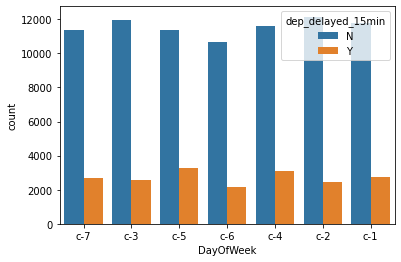

In [9]:
sns.countplot(x="DayOfWeek", data=train, hue='dep_delayed_15min')

###Step 2: prepare data

Separate data for features and target. 
For prepare data (encoding and making new feature) is used class `MakeFeature` from separate package. This class is written special for this data

In [10]:
X_train, y_train = train.drop(['dep_delayed_15min'], axis=1), train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [11]:
mf = MakeFeatures(is_weekend=1, 
                  seasons=1, 
                  day_of_month=1, 
                  dep_capital=1, 
                  arr_capital=1, 
                  route=0, 
                  log_dist=1, 
                  uc=1, 
                  time = 1,
                  new_dep_time = 1,
                  hour_imp = 0)
mf.fit(X_train)

X_train_new = mf.fit_transform(X_train)
X_train_new.head()

Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!
Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!


,Seasons_cos,Seasons_sin,IsWeekend,Day,DepFromCap,ArrForCap,LogDist,Hour,Minute,AA,AQ,AS,B6,CO,DH,DL,EV,F9,FL,HA,HP,MQ,NW,OH,OO,TZ,UA,US,WN,XE,YV,day,evening,morning,night
0,-5.000000e-01,-0.866025,1,21,0,0,6.595781,19,34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-5.000000e-01,0.866025,0,20,0,0,6.726233,15,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,-1.836970e-16,-1.000000,0,2,0,0,6.030685,14,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,8.660254e-01,-0.500000,1,25,0,0,6.770789,10,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,5.000000e-01,-0.866025,1,7,0,0,6.047372,18,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


You can test with different params of MakeFeature. But full settings make the best performance

### Step 3: Cross-validation

Let's separate training data for folds with `StratifiedKFold` class from `sklearn`. 
Make simple `XGBClassifier` instance and see cross-validation score.
Targe metric: ROC-AUC (conditional task).

In [12]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=R_STATE)

In [13]:
xgb_first = XGBClassifier(
                        objective= 'binary:logistic'
                        )
cv_xgb_first = cross_val_score(xgb_first, X=X_train_new.values, y=y_train, cv=skf, scoring="roc_auc", verbose=1)
cv_mean_xgb_first = np.mean(cv_xgb_first)

cv_xgb_first, cv_mean_xgb_first

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.8s finished


(array([0.71239174, 0.71476971, 0.71396586]), 0.7137091032456363)

Now let's see tunung `XGBClassifier`. I tuned it due to four hous with using `RandomSearch` and `GridSearch` classes. Validaton made with cross_val_score and targit metric **ROC-AUC**

In [14]:
xgb = XGBClassifier(learning_rate=0.1,
                        max_depth=4,
                        min_child_weight=2,
                        n_estimators=1000,
                        gamma=0.1,
                        subsamle = 0.9,
                        colsample_bytree = 0.5,
                        reg_alpha = 1.4,
                        objective= 'binary:logistic'
                        )

In [15]:
cv_xgb = cross_val_score(xgb, X=X_train_new.values, y=y_train, cv=skf, scoring="roc_auc", verbose=1)
cv_mean_xgb = np.mean(cv_xgb)

cv_xgb, cv_mean_xgb

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished


(array([0.72723519, 0.73409327, 0.73189532]), 0.7310745929100181)

Let's see difference between based and tuned XGBClassifier

In [16]:
diff_xv_xgb = cv_mean_xgb - cv_mean_xgb_first
diff_xv_xgb

0.017365489664381784

### Step 4: Training with all dataset

Prepare model for final prediction with used all training data.

In [17]:
mf = MakeFeatures(is_weekend=1, 
                  seasons=1, 
                  day_of_month=1, 
                  dep_capital=1, 
                  arr_capital=1, 
                  route=1, 
                  log_dist=1, 
                  uc=1, 
                  time = 1,
                  new_dep_time = 1,
                  hour_imp = 1)
mf.fit(X_train)

X_train_new = mf.fit_transform(X_train)
X_train_new.head()

Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!
Route complete!
Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!
Route complete!


,Seasons_cos,Seasons_sin,IsWeekend,Day,DepFromCap,ArrForCap,LogDist,Hour,Minute,Hour_sq,Hour_sq2,AA,AQ,AS,B6,CO,DH,DL,EV,F9,FL,HA,HP,MQ,NW,OH,OO,TZ,UA,US,WN,XE,YV,ABE_Origin,ABI_Origin,ABQ_Origin,ABY_Origin,ACK_Origin,ACT_Origin,ACV_Origin,...,SMF_Dest,SMX_Dest,SNA_Dest,SOP_Dest,SPI_Dest,SPS_Dest,SRQ_Dest,STL_Dest,STT_Dest,STX_Dest,SUN_Dest,SWF_Dest,SYR_Dest,TEX_Dest,TLH_Dest,TOL_Dest,TPA_Dest,TRI_Dest,TTN_Dest,TUL_Dest,TUP_Dest,TUS_Dest,TVC_Dest,TWF_Dest,TXK_Dest,TYR_Dest,TYS_Dest,VCT_Dest,VIS_Dest,VLD_Dest,VPS_Dest,WRG_Dest,WYS_Dest,XNA_Dest,YAK_Dest,YUM_Dest,day,evening,morning,night
0,-5.000000e-01,-0.866025,1,21,0,0,6.595781,19,34,361,130321,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-5.000000e-01,0.866025,0,20,0,0,6.726233,15,48,225,50625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,-1.836970e-16,-1.000000,0,2,0,0,6.030685,14,22,196,38416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,8.660254e-01,-0.500000,1,25,0,0,6.770789,10,15,100,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5.000000e-01,-0.866025,1,7,0,0,6.047372,18,28,324,104976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


For use model with user data in final Streamlit app save list of final dataset columns.

In [18]:
fid = open('col_train_xgb.txt','w')
series = X_train_new.columns.to_list()

for _, s in enumerate(series):
  fid.writelines(s+'\n')

fid.close()


Check our file.

In [19]:
fid = open('col_train_xgb.txt', 'r')
columns = fid.readlines()
fid.close()
columns

['Seasons_cos\n',
 'Seasons_sin\n',
 'IsWeekend\n',
 'Day\n',
 'DepFromCap\n',
 'ArrForCap\n',
 'LogDist\n',
 'Hour\n',
 'Minute\n',
 'Hour_sq\n',
 'Hour_sq2\n',
 'AA\n',
 'AQ\n',
 'AS\n',
 'B6\n',
 'CO\n',
 'DH\n',
 'DL\n',
 'EV\n',
 'F9\n',
 'FL\n',
 'HA\n',
 'HP\n',
 'MQ\n',
 'NW\n',
 'OH\n',
 'OO\n',
 'TZ\n',
 'UA\n',
 'US\n',
 'WN\n',
 'XE\n',
 'YV\n',
 'ABE_Origin\n',
 'ABI_Origin\n',
 'ABQ_Origin\n',
 'ABY_Origin\n',
 'ACK_Origin\n',
 'ACT_Origin\n',
 'ACV_Origin\n',
 'ACY_Origin\n',
 'ADK_Origin\n',
 'ADQ_Origin\n',
 'AEX_Origin\n',
 'AGS_Origin\n',
 'AKN_Origin\n',
 'ALB_Origin\n',
 'AMA_Origin\n',
 'ANC_Origin\n',
 'APF_Origin\n',
 'ASE_Origin\n',
 'ATL_Origin\n',
 'ATW_Origin\n',
 'AUS_Origin\n',
 'AVL_Origin\n',
 'AVP_Origin\n',
 'AZO_Origin\n',
 'BDL_Origin\n',
 'BET_Origin\n',
 'BFL_Origin\n',
 'BGM_Origin\n',
 'BGR_Origin\n',
 'BHM_Origin\n',
 'BIL_Origin\n',
 'BIS_Origin\n',
 'BLI_Origin\n',
 'BMI_Origin\n',
 'BNA_Origin\n',
 'BOI_Origin\n',
 'BOS_Origin\n',
 'BPT_Origi

Refit our model with using all dataset

In [20]:
xgb.fit(X_train_new.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsamle=0.9, subsample=1, verbosity=1)

Save the trained model for use in future applications.

In [21]:
PATH_XGB = 'xgb'

if not os.path.exists(PATH_XGB):
    os.mkdir(PATH_XGB)

xgb.save_model(PATH_XGB+'/xgbclf_save_model.model')

Check saving model. Prediction should be equal.

In [22]:
from xgboost import Booster

clf_loaded = XGBClassifier()
booster = Booster()
booster.load_model(PATH_XGB+'/xgbclf_save_model.model')
clf_loaded._Booster = booster

predict = xgb.predict_proba(X_train_new.values)[:, 1]
predict_load =  clf_loaded.predict_proba(X_train_new.values)[:, 1]

predict, predict_load

(array([0.4328614 , 0.20461528, 0.10008893, ..., 0.21750088, 0.17728072,
        0.24874607], dtype=float32),
 array([0.4328614 , 0.20461528, 0.10008893, ..., 0.21750088, 0.17728072,
        0.24874607], dtype=float32))

Now we are ready to use test dataset!

### Step 5: Make predict

Prepare our test dataset with use the same pipeline.

In [23]:
mf_test = MakeFeatures(is_weekend=1, 
                  seasons=1, 
                  day_of_month=1, 
                  dep_capital=1, 
                  arr_capital=1, 
                  route=1, 
                  log_dist=1, 
                  uc=1, 
                  time = 1,
                  new_dep_time = 1,
                  hour_imp = 1)
mf_test.fit(test)

X_test = mf_test.fit_transform(test)
X_test.head()

Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!
Route complete!
Seasons complete!
IsWeekend complete!
TimeOfDay complete!
Day complete!
DepFromCap complete!
ArrivInCap complete!
LogDist complete!
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!
Route complete!


,Seasons_cos,Seasons_sin,IsWeekend,Day,DepFromCap,ArrForCap,LogDist,Hour,Minute,Hour_sq,Hour_sq2,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV,ABE_Origin,ABI_Origin,ABQ_Origin,ABY_Origin,ACK_Origin,ACT_Origin,ACV_Origin,ACY_Origin,ADK_Origin,...,SLE_Dest,SMF_Dest,SMX_Dest,SNA_Dest,SOP_Dest,SPI_Dest,SPS_Dest,SRQ_Dest,STL_Dest,STT_Dest,STX_Dest,SUN_Dest,SUX_Dest,SWF_Dest,SYR_Dest,TLH_Dest,TOL_Dest,TPA_Dest,TRI_Dest,TTN_Dest,TUL_Dest,TUP_Dest,TUS_Dest,TVC_Dest,TWF_Dest,TXK_Dest,TYR_Dest,TYS_Dest,VLD_Dest,VPS_Dest,WRG_Dest,WYS_Dest,XNA_Dest,YAK_Dest,YKM_Dest,YUM_Dest,day,evening,morning,night
0,-8.660254e-01,-5.000000e-01,0,25,0,0,6.393591,6,15,36,1296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-5.000000e-01,8.660254e-01,0,17,0,0,7.118826,7,39,49,2401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1.000000e+00,-2.449294e-16,1,2,0,0,6.357842,6,51,36,1296,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6.123234e-17,1.000000e+00,1,25,1,0,5.932245,16,14,256,65536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,-1.000000e+00,1.224647e-16,0,6,0,0,5.552960,15,5,225,50625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


We cant make predict right now. Because there are differences between train and teat prepared dataset:

In [24]:
set(X_test.columns)-set(X_train_new.columns), set(X_train_new.columns)-set(X_test.columns)

({'9E',
  'ADK_Dest',
  'ALO_Dest',
  'ALO_Origin',
  'BJI_Dest',
  'BJI_Origin',
  'CMX_Dest',
  'CMX_Origin',
  'EAU_Dest',
  'EAU_Origin',
  'ELM_Dest',
  'ELM_Origin',
  'EWN_Dest',
  'EWN_Origin',
  'HHH_Dest',
  'HHH_Origin',
  'INL_Dest',
  'INL_Origin',
  'MTH_Dest',
  'MTH_Origin',
  'OAJ_Dest',
  'PLN_Dest',
  'PLN_Origin',
  'PMD_Dest',
  'PMD_Origin',
  'RHI_Dest',
  'RHI_Origin',
  'ROW_Dest',
  'ROW_Origin',
  'SLE_Dest',
  'SLE_Origin',
  'SOP_Origin',
  'SUX_Dest',
  'SUX_Origin',
  'TTN_Origin',
  'YKM_Dest',
  'YKM_Origin'},
 {'CDC_Dest',
  'CDC_Origin',
  'DH',
  'GST_Dest',
  'HKY_Dest',
  'HKY_Origin',
  'HP',
  'HVN_Dest',
  'HVN_Origin',
  'ISO_Dest',
  'ISO_Origin',
  'PIE_Dest',
  'PIE_Origin',
  'TEX_Dest',
  'TZ',
  'VCT_Dest',
  'VCT_Origin',
  'VIS_Dest',
  'VIS_Origin'})

This is correct beacause training fearures *Dest, Origin and UniqueCarrier* have values, that are not in test dataset. Opposite statement is also true.

So make function for eliminate this discrepancy. We can use this function in future app.

In [25]:
def prepare_test_data(df_train: pd.DataFrame, df_test: pd.DataFrame):

  new_cols_test = set(df_test.columns)-set(df_train.columns)
  new_cols_train = set(df_train.columns)-set(df_test.columns)

  X_test.drop(new_cols_test, axis=1, inplace=True)

  for _, val in enumerate(new_cols_train):
    X_test[val] = 0

  df_test.Day = df_test.Day.map(int)
  neworder = df_train.columns
  df_test_new = df_test.reindex(columns=neworder)

  return df_test_new, set(df_train.columns)-set(df_test_new.columns), set(df_test_new.columns)-set(df_train.columns)

In [26]:
X_test_new, diff_cols_train, diff_cols_test = prepare_test_data(X_train_new, X_test)

diff_cols_train, diff_cols_test, X_test_new.head()

(set(),
 set(),
     Seasons_cos   Seasons_sin  IsWeekend  Day  ...  day  evening  morning  night
 0 -8.660254e-01 -5.000000e-01          0   25  ...    0        0        0      1
 1 -5.000000e-01  8.660254e-01          0   17  ...    0        0        1      0
 2  1.000000e+00 -2.449294e-16          1    2  ...    0        0        0      1
 3  6.123234e-17  1.000000e+00          1   25  ...    1        0        0      0
 4 -1.000000e+00  1.224647e-16          0    6  ...    1        0        0      0
 
 [5 rows x 615 columns])

Finish line, make prediction!

In [27]:
predict_kaggle = xgb.predict_proba(X_test_new.values)[:, 1]
predict_kaggle

array([0.03998995, 0.05900993, 0.03185375, ..., 0.21175021, 0.11470821,
       0.0861673 ], dtype=float32)

That's all. Make .csv file and send for Kaggle.
This pipeline have score 0.73106. 

In [28]:
make_predict(predict_kaggle,'xgb_all_data')